# Fake News Project

The goal of this project is to tell true and fake news apart based on their title and body. In order to do so, we are going to follow two approaches. First of all, we are going to build a machine learning model, as well as try to come up with heuristic rules that can help us know when a piece of news is fake. After that, in a separate notebook, we are going to build an NLP model.

## Imports

First of all, let's go ahead and get all the necessary imports ready.

In [47]:
import re

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from lime.lime_text import LimeTextExplainer
from matplotlib import pyplot as plt
from pycaret.classification import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, \
    confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from biased_token_remover import BiasedTokenRemover
from utils import (count_uppercase_words, get_uppercase_word_ratio, get_ngrams,
                   count_words)

## Data Preprocessing

For this project, we have two datasets: Fake and True. Let's load them and take a look at their features.

In [132]:
df_fake = pd.read_csv('data/Fake.csv')
df_true = pd.read_csv('data/True.csv')

In [133]:
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [134]:
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

As we can see, they both have four columns: title, text, subject, and date. In this case, we are only interested in the first two columns, so we will focus on those.

### Invalid Dates

Some articles seem to contain just a link. In those cases, the link also appears in the date column, so it is easy to filter them out.

In [138]:
valid_dates_fake = pd.to_datetime(df_fake['date'], errors='coerce')

df_fake[valid_dates_fake.isna()].head()

title  \
9358   https://100percentfedup.com/served-roy-moore-v...   
15507  https://100percentfedup.com/video-hillary-aske...   
15508  https://100percentfedup.com/12-yr-old-black-co...   
15839  https://fedup.wpengine.com/wp-content/uploads/...   
15840  https://fedup.wpengine.com/wp-content/uploads/...   

                                                    text   subject  \
9358   https://100percentfedup.com/served-roy-moore-v...  politics   
15507  https://100percentfedup.com/video-hillary-aske...  politics   
15508  https://100percentfedup.com/12-yr-old-black-co...  politics   
15839  https://fedup.wpengine.com/wp-content/uploads/...  politics   
15840  https://fedup.wpengine.com/wp-content/uploads/...  politics   

                                                    date  
9358   https://100percentfedup.com/served-roy-moore-v...  
15507  https://100percentfedup.com/video-hillary-aske...  
15508  https://100percentfedup.com/12-yr-old-black-co...  
15839  https://fedup.wpengine.com/wp-content/uploads/...  
15840  https://fedup.wpengine.com/wp-content/uploads/...

In [139]:
df_fake[valid_dates_fake.isna()].shape

(10, 4)

In [140]:
df_fake = df_fake[~valid_dates.isna()]

In [141]:
valid_dates_true = pd.to_datetime(df_true['date'], errors='coerce')

invalid_dates_true = df_true[valid_dates_true.isna()]

invalid_dates_true

Empty DataFrame
Columns: [title, text, subject, date]
Index: []

### Drop Duplicates and Irrelevant Features

Before combining our datasets, we want to make sure we don't have any duplicate rows.

In [142]:
df_fake[df_fake[['title', 'text']].duplicated()].shape

(5569, 4)

In [143]:
df_fake[df_fake[['title', 'text']].duplicated()][['title','text']].head()

title  \
9942   HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...   
11446  FORMER DEMOCRAT WARNS Young Americans: “Rioter...   
14925  [VIDEO] #BlackLivesMatter Terrorists Storm Dar...   
15892  HOUSE INTEL Slaps Subpoenas on McCain Institut...   
15893  PRICELESS! WATCH MSNBC HOST’S Shocked Response...   

                                                    text  
9942   No time to waste   we've got to fight with eve...  
11446   Who is silencing political speech, physically...  
14925  They were probably just looking for a  safe sp...  
15892  Please see our previous report below on the Mc...  
15893  THIS IS PRICELESS! The video below shows just ...

In [144]:
df_true[df_true[['title', 'text']].duplicated()].shape

(220, 4)

In [145]:
df_true[df_true[['title', 'text']].duplicated()][['title','text']].head()

title  \
445  Senate tax bill stalls on deficit-focused 'tri...   
778  Trump warns 'rogue regime' North Korea of grav...   
892  Republicans unveil tax cut bill, but the hard ...   
896  Trump taps Fed centrist Powell to lead U.S. ce...   
974  Two ex-Trump aides charged in Russia probe, th...   

                                                  text  
445  WASHINGTON (Reuters) - The U.S. Senate on Thur...  
778  BEIJING (Reuters) - U.S. President Donald Trum...  
892  WASHINGTON (Reuters) - U.S. House of Represent...  
896  WASHINGTON (Reuters) - President Donald Trump ...  
974  WASHINGTON (Reuters) - Federal investigators p...

As we can see, we have almost 6000 duplicates in total, let's remove them.

In [146]:
df_fake = df_fake[['title', 'text']].drop_duplicates()

In [147]:
df_true = df_true[['title', 'text']].drop_duplicates()

In [148]:
print(f"""Number of True News: {df_true.shape[0]}
Number of Fake News: {df_fake.shape[0]}""")

Number of True News: 21197
Number of Fake News: 17902


Finally, let's join both datasets, adding a column, is_true, for classification purposes.

In [149]:
df_fake['is_true'] = 0
df_true['is_true'] = 1
df_all = pd.concat([df_fake, df_true])

In [150]:
df_all.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  is_true  
0  Donald Trump just couldn t wish all Americans ...        0  
1  House Intelligence Committee Chairman Devin Nu...        0  
2  On Friday, it was revealed that former Milwauk...        0  
3  On Christmas day, Donald Trump announced that ...        0  
4  Pope Francis used his annual Christmas Day mes...        0

In [151]:
df_all.reset_index(drop=True, inplace=True)

### Text Analysis

Let's see what are the most common bigrams and trigrams for both classes.

In [155]:
common_words_true = get_ngrams(df_true['text'], 1)
common_words_fake = get_ngrams(df_fake['text'], 1)

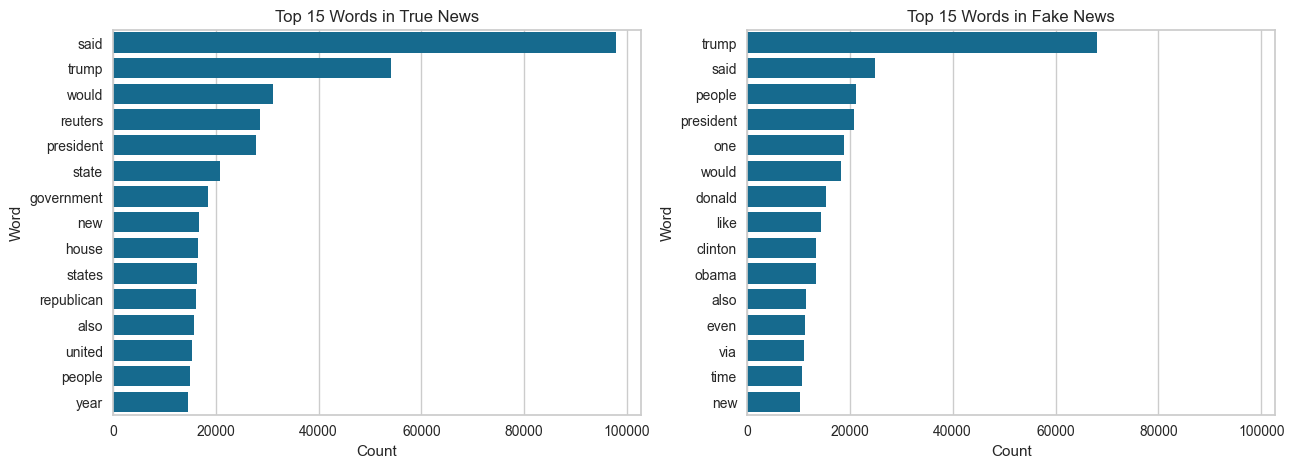

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex='all')

sns.barplot(x='count', y='ngram', data=common_words_true.head(15), ax=axes[0])
axes[0].set_title('Top 15 Words in True News')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')

sns.barplot(x='count', y='ngram', data=common_words_fake.head(15), ax=axes[1])
axes[1].set_title('Top 15 Words in Fake News')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')
plt.show()

In [ ]:
bigrams_true = get_ngrams(df_true['text'], 2)
bigrams_fake = get_ngrams(df_fake['text'], 2)
trigrams_true = get_ngrams(df_true['text'], 3)
trigrams_fake = get_ngrams(df_fake['text'], 3)

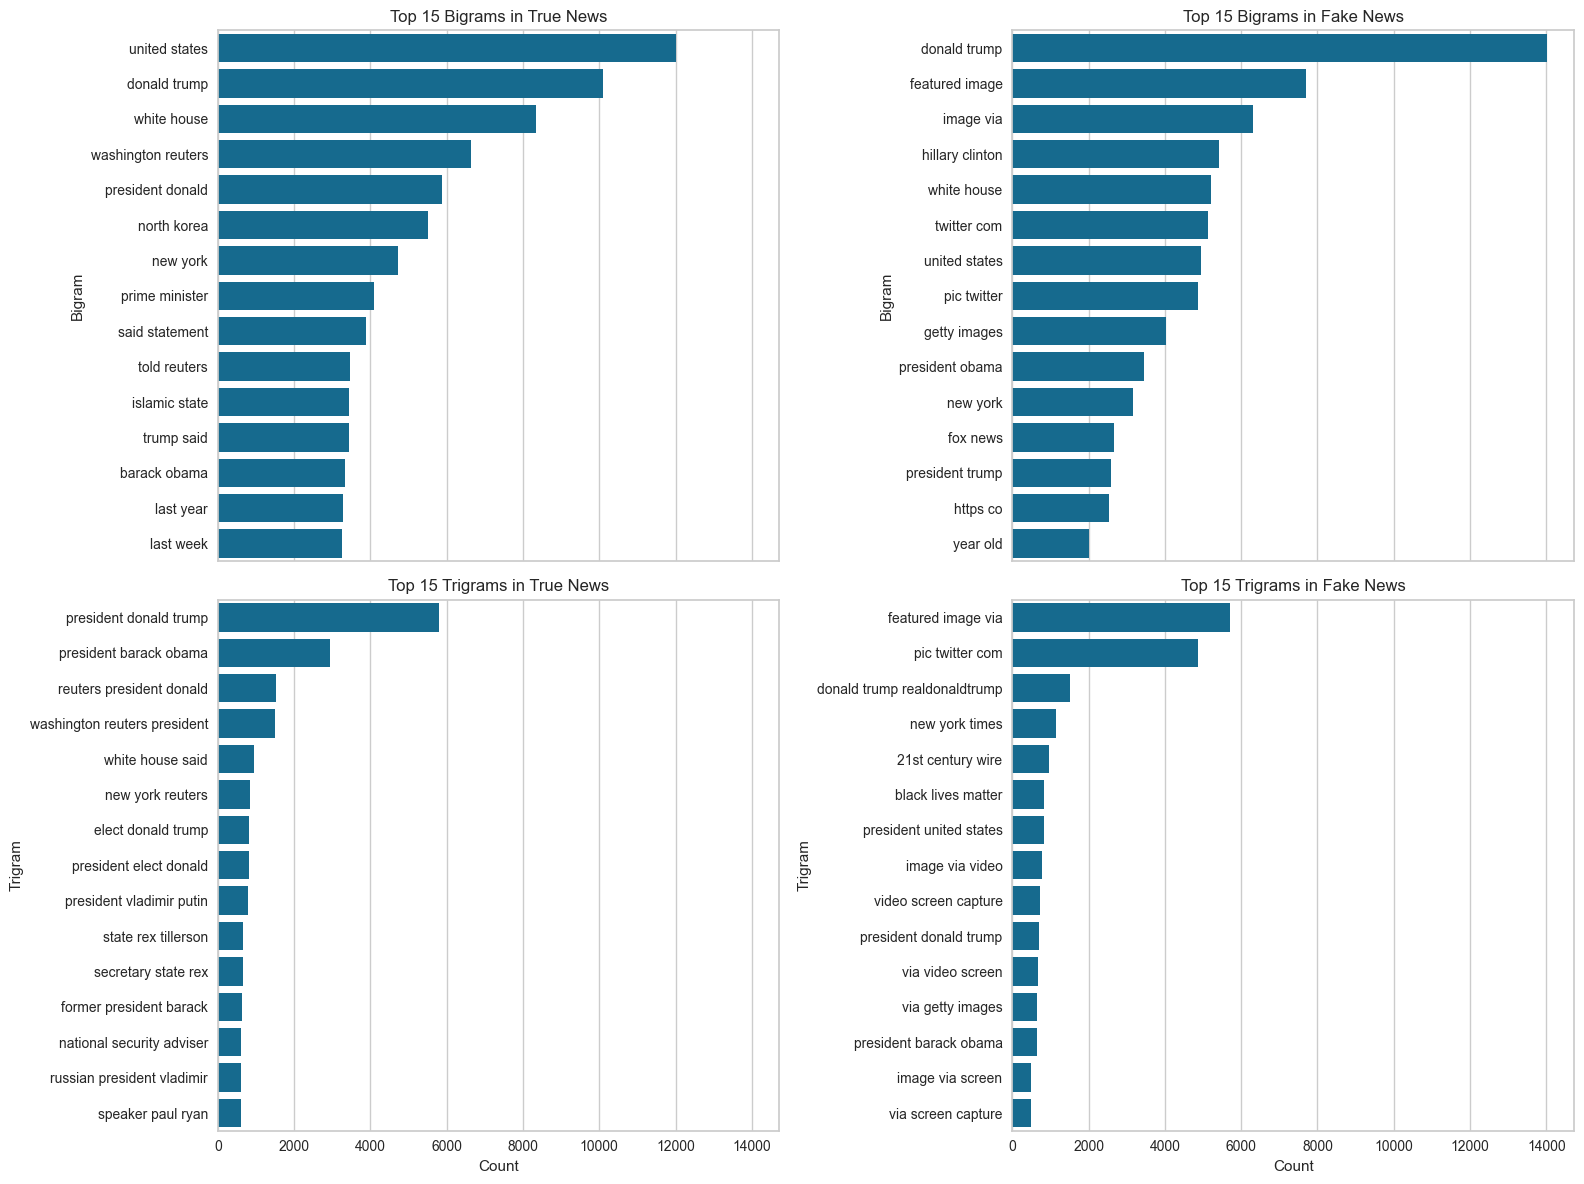

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex='all')

sns.barplot(x='count', y='ngram', data=bigrams_true.head(15), ax=axes[0, 0])
axes[0, 0].set_title('Top 15 Bigrams in True News')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Bigram')

sns.barplot(x='count', y='ngram', data=bigrams_fake.head(15), ax=axes[0, 1])
axes[0, 1].set_title('Top 15 Bigrams in Fake News')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Bigram')

sns.barplot(x='count', y='ngram', data=trigrams_true.head(15), ax=axes[1, 0])
axes[1, 0].set_title('Top 15 Trigrams in True News')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Trigram')

sns.barplot(x='count', y='ngram', data=trigrams_fake.head(15), ax=axes[1, 1])
axes[1, 1].set_title('Top 15 Trigrams in Fake News')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Trigram')

plt.tight_layout()
plt.show()

As we can see, the most common n-grams for true news are people (Donald 
Trump, Vladimir Putin), places (North Korea, Washington), and times (last 
week, last year). Similarly, news agency Reuters is featured twice.
 
As for fake news, we see mostly references to image and video sources, Twitter, 
several news outlets, especially when it comes to trigrams.

## Preliminary Model

### Reuters

Now our goal is to engineer features that allow us to predict whether a piece of news is true or not. We see that most articles in the df_true dataset mention news agency Reuters at the beginning of their body. That means that we can probably tell which dataset an article belongs to based on whether Reuters is mentioned or not.

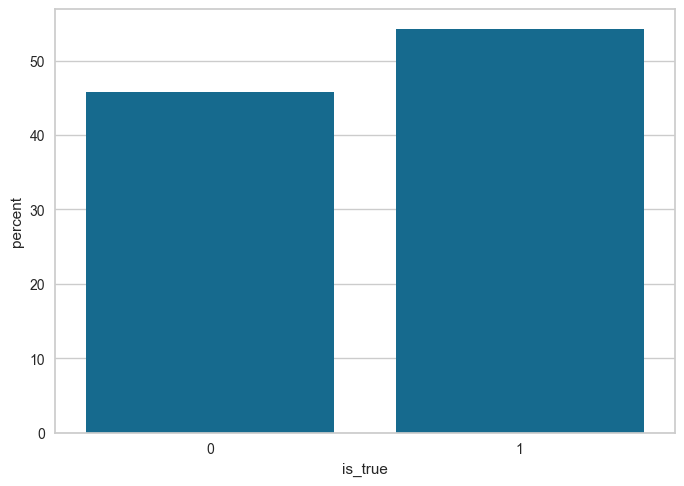

In [163]:
sns.countplot(x='is_true', data=df_all, stat='percent')
plt.show()

In [164]:
df_all['text_contains_reuters'] = (
    df_all.text.apply(lambda x: x.find('Reuters') != -1)
    .map({True: 1, False: 0}))

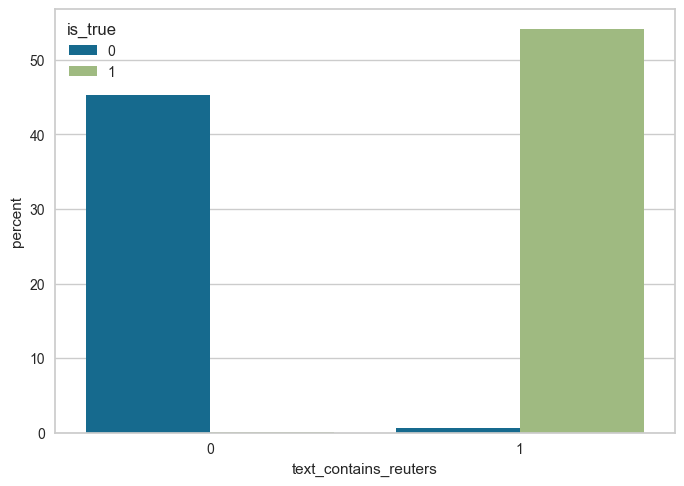

In [165]:
sns.countplot(df_all, x='text_contains_reuters', hue='is_true', stat='percent')
plt.show()

While that is not always the case, we would probably get it right in almost all cases. Let's see what that would look like if we created such a model.

#### "Modelling"

In [166]:
X = df_all.drop('is_true', axis=1)
y = df_all['is_true']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                stratify=y_test)

              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      2685
        True       0.99      1.00      0.99      3180

    accuracy                           0.99      5865
   macro avg       0.99      0.99      0.99      5865
weighted avg       0.99      0.99      0.99      5865



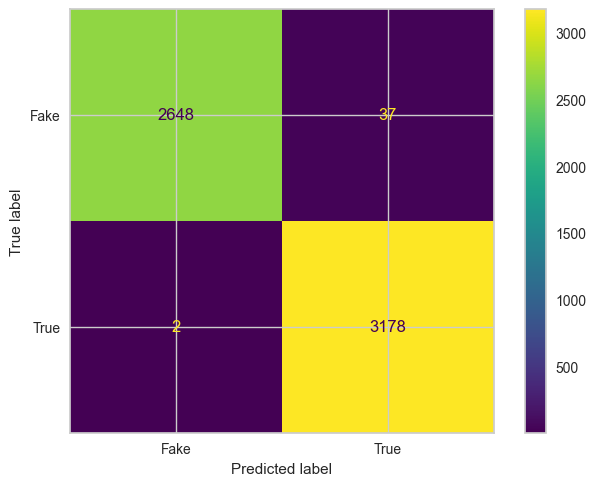

In [167]:
print(classification_report(y_val, X_val.text_contains_reuters,
                            target_names=['Fake', 'True']))
cm = confusion_matrix(y_val, X_val.text_contains_reuters)
ConfusionMatrixDisplay(cm, display_labels=['Fake', 'True']).plot()
plt.show()

Indeed, we got an almost perfect score. Unfortunately, this is not a feature we can rely on if we want to build a robust model. For the next part, we are going to remove mentions to the location and news agency where the story was written.

## Models Using Feature Engineering

As we can see below, true news always start with a mention to Reuters, and 
usually also the place where the article was written. We are going to remove 
this section, since we don't want our model to be biased. Similarly, we are 
also going to remove any other mention of Reuters.

As for fake news, we will remove any mention of featured images.

In [168]:
df_true['text'].apply(lambda x: x.split(' - ')[0]).value_counts().head(10)

WASHINGTON (Reuters)    6356
(Reuters)               1461
LONDON (Reuters)         697
NEW YORK (Reuters)       694
MOSCOW (Reuters)         615
BERLIN (Reuters)         496
BEIJING (Reuters)        425
BRUSSELS (Reuters)       343
BEIRUT (Reuters)         338
PARIS (Reuters)          297
Name: text, dtype: int64

In [169]:
df_true['text'] = df_true['text'].apply(
    lambda x: x.split(' -', 1)[1] if ' -' in x else x)
df_fake['text'] = df_fake['text'].apply(lambda x: x.split('Featured image')[0])

df_all = pd.concat([df_fake, df_true])

compiled = re.compile(re.escape('reuters'), re.IGNORECASE)

df_all['text'] = df_all['text'].apply(lambda x: str(compiled.sub('', x)))
df_all['title'] = df_all['title'].apply(lambda x: str(compiled.sub('', x)))

### Adding Number of Words as Feature

Another feature we can use is the number of words in text and title. Let's 
see if we can find any pattern across classes.

In [170]:
df_all['n_words_title'] = df_all.title.apply(count_words)
df_all['n_words_text'] = df_all.text.apply(count_words)

In [171]:
df_all.reset_index(drop=True, inplace=True)

In [172]:
df_all.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  is_true  n_words_title  \
0  Donald Trump just couldn t wish all Americans ...        0             13   
1  House Intelligence Committee Chairman Devin Nu...        0              9   
2  On Friday, it was revealed that former Milwauk...        0             16   
3  On Christmas day, Donald Trump announced that ...        0             15   
4  Pope Francis used his annual Christmas Day mes...        0             12   

   n_words_text  
0           516  
1           309  
2           600  
3           475  
4           434

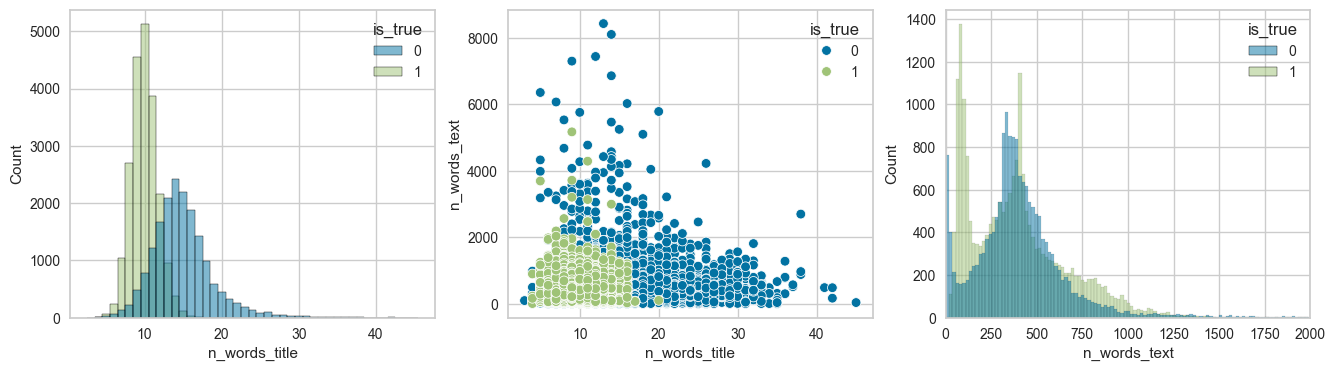

In [178]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(data=df_all, x='n_words_title', hue='is_true', discrete=True,
             ax=axes[0])
sns.scatterplot(data=df_all, x='n_words_title', y='n_words_text',
                hue='is_true', ax=axes[1])
sns.histplot(data=df_all, x='n_words_text', hue='is_true',
             ax=axes[2])
plt.xlim([0, 2000])
plt.show()

Fake news tend to have more verbose titles, while true news are more succinct
. As for the news body, we see two distinct peaks for each class. 

Finally, If we take a look at the scatter plot, we see how the great majority
 of true news have less than 20 words in the title, and less than 2000 in the body.

#### Modelling

One easy way to create a preliminary model is to use PyCaret. PyCaret is a Python library that automates the end-to-end machine learning workflow. We can compare different models and tune the best one.

In [179]:
X = df_all[['n_words_title', 'n_words_text']]
y = df_all['is_true']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                stratify=y_test)

In [182]:
setup(data=pd.concat([X_train, y_train], axis=1), target='is_true',
      test_data=pd.concat([X_val, y_val], axis=1))

In [23]:
best_model_n_words = compare_models(sort='f1')

In [25]:
best_model_n_words = tune_model(best_model_n_words, n_iter=100)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [26]:
save_model(best_model_n_words, 'models/model_n_words')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['n_words_title', 'n_words_text'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(add_indicator=False,
                       

In [181]:
best_model_n_words=load_model('models/model_n_words')

Transformation Pipeline and Model Successfully Loaded


As we can see, the most suitable model for this dataset was the Gradient Boosting Classifier. Now we can plot its performance.

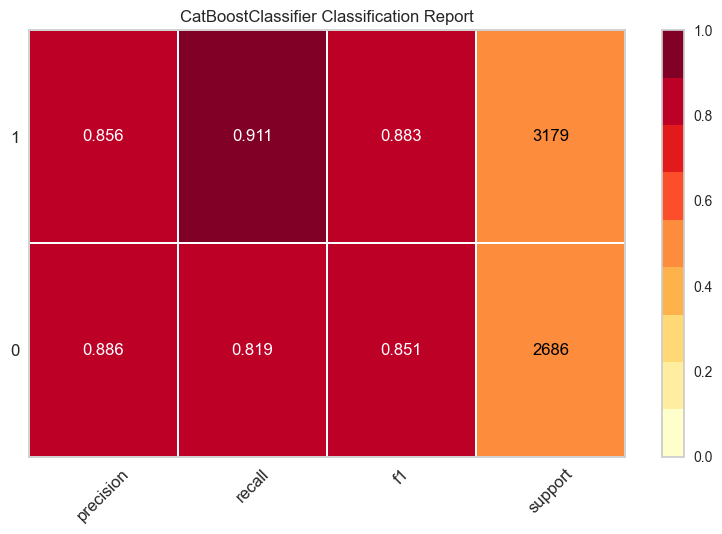

In [183]:
plot_model(best_model_n_words, 'class_report')

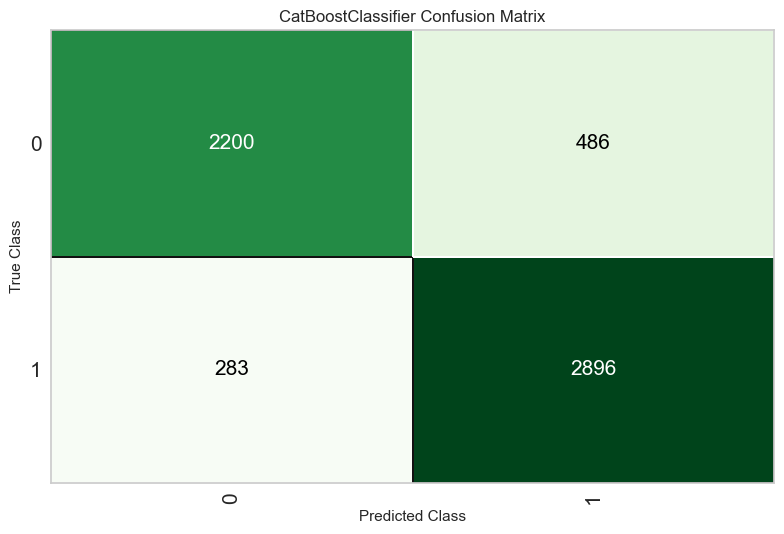

In [184]:
plot_model(best_model_n_words, 'confusion_matrix')

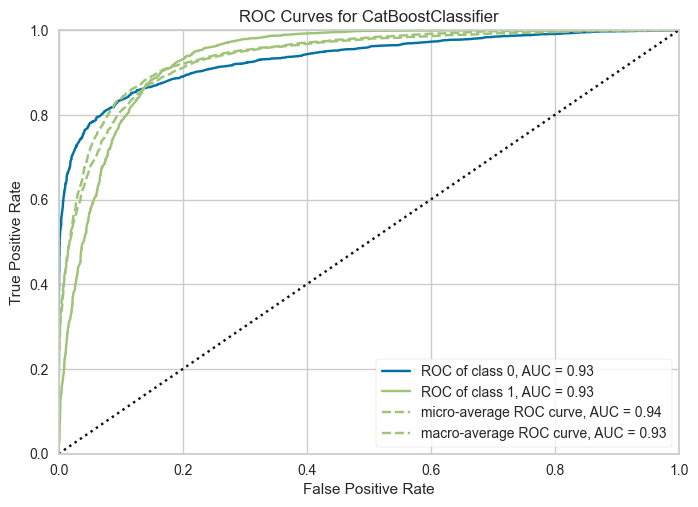

In [185]:
plot_model(best_model_n_words, 'auc')

In [34]:
pred_val = predict_model(best_model_n_words,
                         data=pd.concat([X_val, y_val], axis=1))

Although the results are slightly worse than in the first iteration, our model is now much more generalisable now. Now, we are going to analyse the wrongly predicted samples to see if we can see any patterns.

In [35]:
df_wrong = pred_val[pred_val.is_true != pred_val.prediction_label]
df_right = pred_val[pred_val.is_true == pred_val.prediction_label]

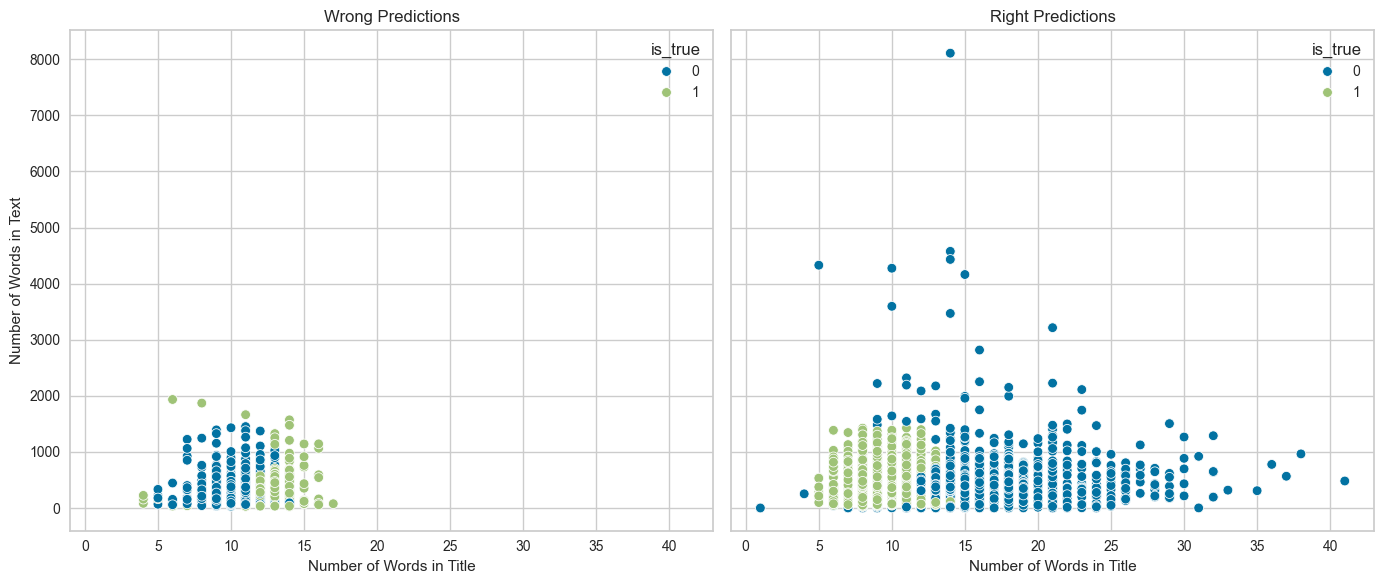

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex='row', sharey='row')

sns.scatterplot(ax=axes[0], x=df_wrong['n_words_title'],
                y=df_wrong['n_words_text'],
                hue=df_wrong['is_true'])
axes[0].set_title('Wrong Predictions')
axes[0].set_xlabel('Number of Words in Title')
axes[0].set_ylabel('Number of Words in Text')

sns.scatterplot(ax=axes[1], x=df_right['n_words_title'],
                y=df_right['n_words_text'],
                hue=df_right['is_true'])
axes[1].set_title('Right Predictions')
axes[1].set_xlabel('Number of Words in Title')
axes[1].set_ylabel('Number of Words in Text')

plt.tight_layout()
plt.show()

In this case, the pattern is rather clear: our model struggles with articles with titles between 3 and 20 words, as articles with a longer word count in the title are practically always false in our database. Let's try adding more features to create new patterns.

### Number of Capitalised WORDS

If we compare both datasets, we can notice that fake news tend to have more capitalised words, probably as an attempt to grab our attention. This could be a key feature to help our model distinguish between both classes, especially for the cases where it struggled in the previous iteration.

In [27]:
df_all['n_capitalised_words_title'] = df_all['title'].apply(
    count_uppercase_words)
df_all['n_capitalised_words_text'] = df_all['text'].apply(count_uppercase_words)
df_all['ratio_capitalised_words_title'] = df_all['title'].apply(
    get_uppercase_word_ratio)
df_all['ratio_capitalised_words_text'] = df_all['text'].apply(
    get_uppercase_word_ratio)

In [28]:
df_all.reset_index(drop=True, inplace=True)

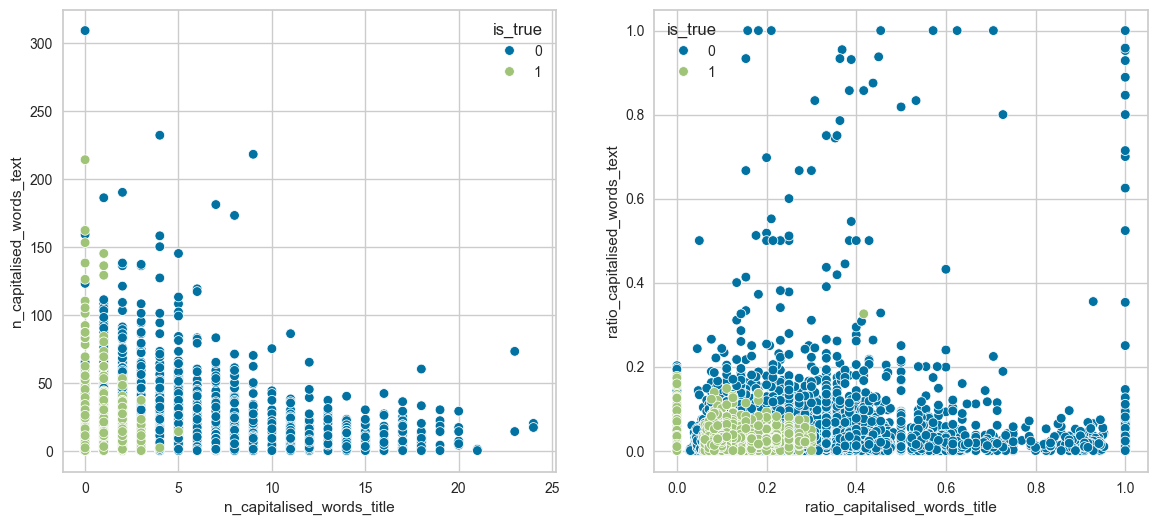

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=df_all, x='n_capitalised_words_title',
                y='n_capitalised_words_text',
                hue='is_true', ax=axes[0])
sns.scatterplot(data=df_all, x='ratio_capitalised_words_title',
                y='ratio_capitalised_words_text',
                hue='is_true', ax=axes[1])
plt.show()

As we can see, true news have significantly less capitalised words. Many of them do not contain any capitalised words in the title and, when they do, the ratio is almost exclusively lower than 0.3 capitalised words per total of words. As for the title, almost all articles have a ratio lower than 0.2.

#### Modelling

In [187]:
X = df_all.drop(['text', 'title', 'is_true'], axis=1)
y = df_all['is_true']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                stratify=y_test)

In [188]:
setup(data=pd.concat([X_train, y_train], axis=1), target='is_true',
      test_data=pd.concat([X_val, y_val], axis=1))
best_model = compare_models(sort='f1')

In [189]:
best_model = tune_model(best_model, n_iter=100)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


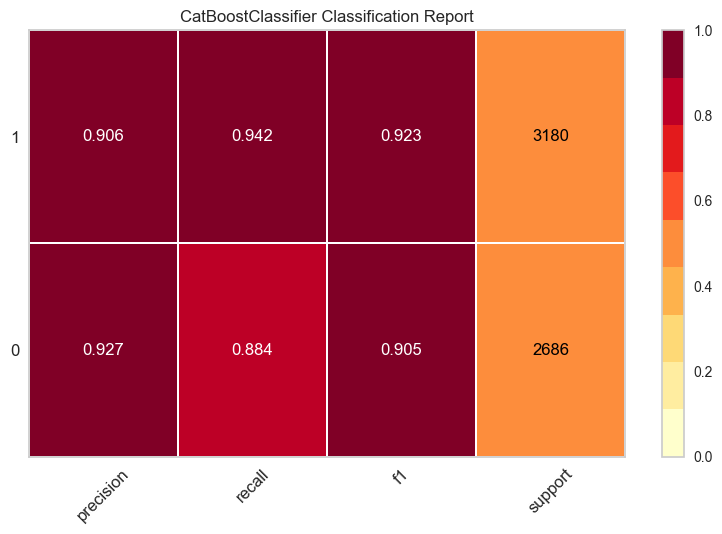

In [197]:
plot_model(best_model, 'class_report')

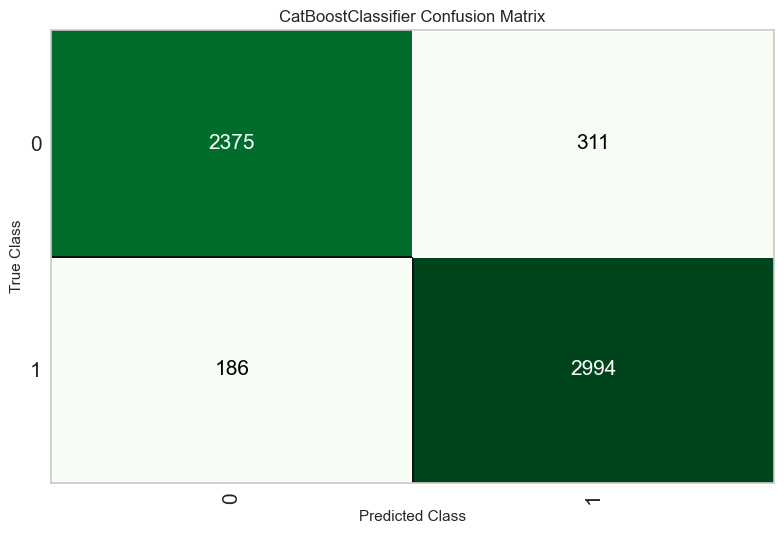

In [191]:
plot_model(best_model, 'confusion_matrix')

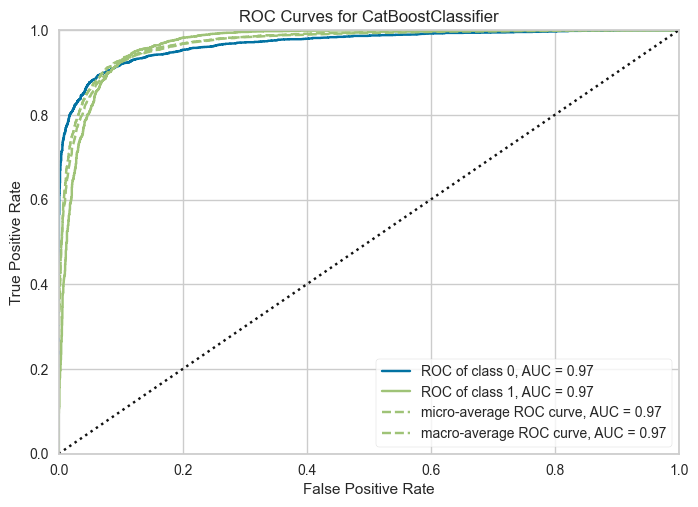

In [208]:
plot_model(best_model, 'auc')

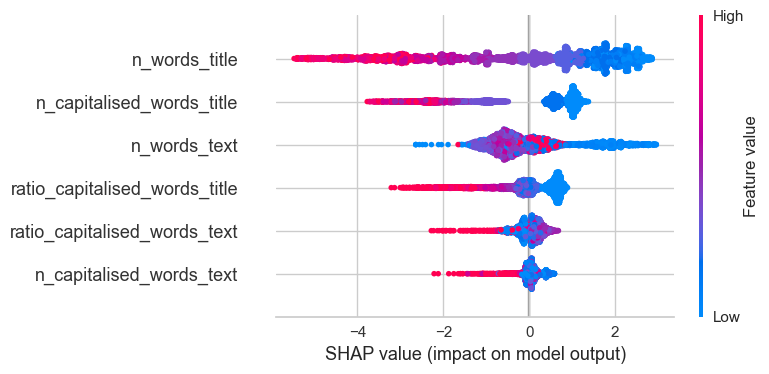

In [209]:
interpret_model(best_model)

As we can see, the more capitalised words an article has, the more likely it is for it to be fake.

In [210]:
save_model(best_model, 'model_capitalised_features')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['n_words_title', 'n_words_text',
                                              'n_capitalised_words_title',
                                              'n_capitalised_words_text',
                                              'ratio_capitalised_words_title',
                                              'ratio_capitalised_words_text'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=F...
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  Transformer

In [193]:
pred_val = predict_model(best_model, data=pd.concat([X_val, y_val], axis=1))

In [194]:
df_wrong = pred_val[pred_val.is_true != pred_val.prediction_label]
df_right = pred_val[pred_val.is_true == pred_val.prediction_label]

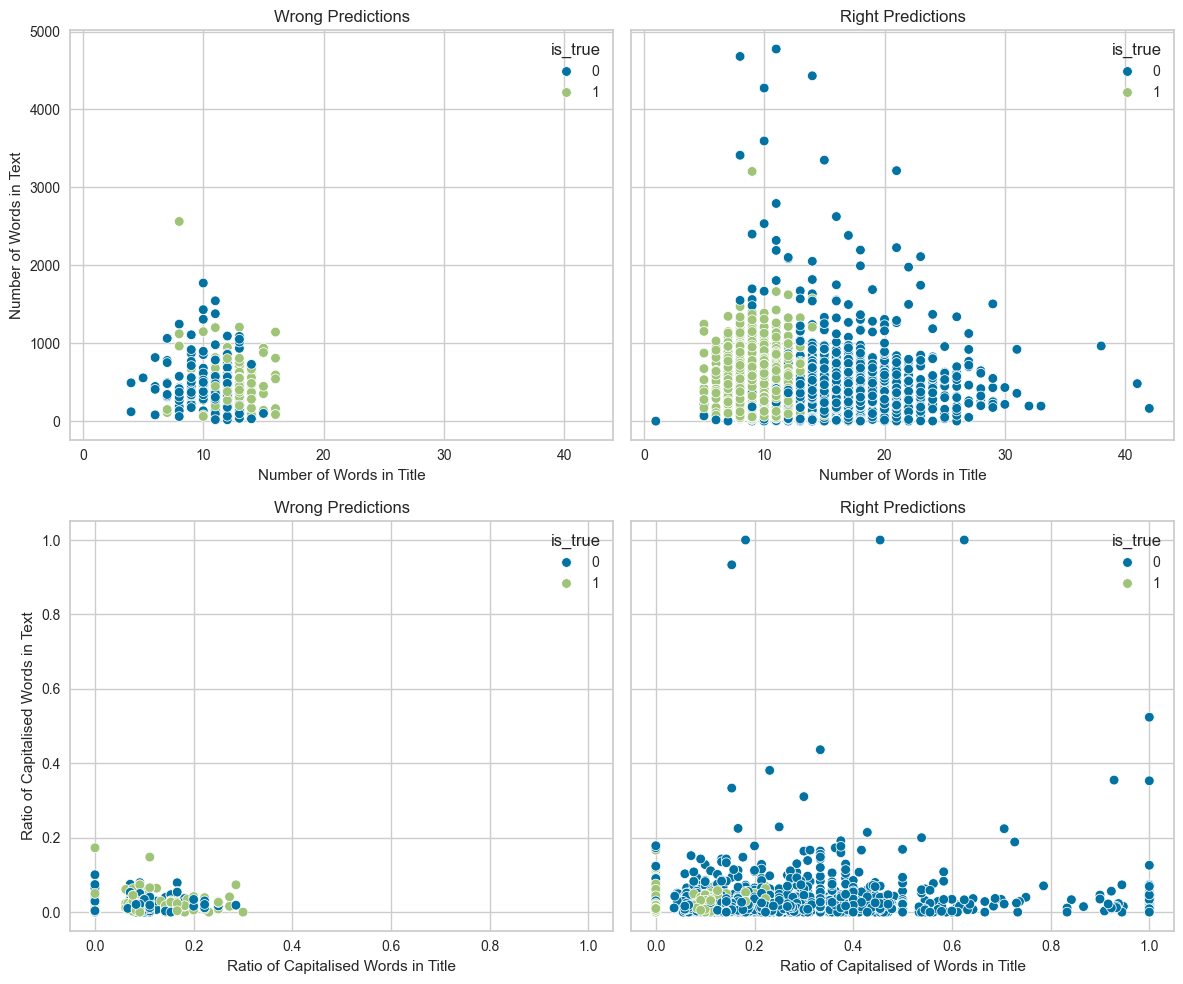

In [200]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex='row', sharey='row')

sns.scatterplot(ax=axes[0, 0], x=df_wrong['n_words_title'],
                y=df_wrong['n_words_text'],
                hue=df_wrong['is_true'])
axes[0, 0].set_title('Wrong Predictions')
axes[0, 0].set_xlabel('Number of Words in Title')
axes[0, 0].set_ylabel('Number of Words in Text')

sns.scatterplot(ax=axes[0, 1], x=df_right['n_words_title'],
                y=df_right['n_words_text'],
                hue=df_right['is_true'])
axes[0, 1].set_title('Right Predictions')
axes[0, 1].set_xlabel('Number of Words in Title')
axes[0, 1].set_ylabel('Number of Words in Text')
sns.scatterplot(ax=axes[1, 0], x=df_wrong['ratio_capitalised_words_title'],
                y=df_wrong['ratio_capitalised_words_text'],
                hue=df_wrong['is_true'])
axes[1, 0].set_title('Wrong Predictions')
axes[1, 0].set_xlabel('Ratio of Capitalised Words in Title')
axes[1, 0].set_ylabel('Ratio of Capitalised Words in Text')

sns.scatterplot(ax=axes[1, 1], x=df_right['ratio_capitalised_words_title'],
                y=df_right['ratio_capitalised_words_text'],
                hue=df_right['is_true'])
axes[1, 1].set_title('Right Predictions')
axes[1, 1].set_xlabel('Ratio of Capitalised of Words in Title')
axes[1, 1].set_ylabel('Ratio of Capitalised of Words in Text')

plt.tight_layout()
plt.show()

While the number of predicted features is significantly lower, our model still has issues with the same type of sample. For our last ML iterations, we are going to use TF-IDF vectors.

### TF-IDF Vectorizer

So far, we have not really used the text itself as a feature for our models. One way to do that is using a TF-IDF vectorizer. TF-IDF stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus.

#### Modelling

In [30]:
df_all.reset_index(drop=True, inplace=True)

In [31]:
X = df_all.drop('is_true', axis=1)
y = df_all['is_true']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                stratify=y_test)

In [62]:
preprocessor = ColumnTransformer(
    transformers=[
        ('title_preprocessor', Pipeline([
            ('vectorizer', TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"))
        ]), 'title'),
        ('text_preprocessor', Pipeline([
            ('vectorizer', TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"))
        ]), 'text'),
        ('num_features', 'passthrough', ['n_words_title', 'n_words_text',
                                         'n_capitalised_words_title',
                                         'n_capitalised_words_text',
                                         'ratio_capitalised_words_title',
                                         'ratio_capitalised_words_text'])
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_val)

In [56]:
print(classification_report(y_val, y_pred, target_names=['Fake', 'True']))

              precision    recall  f1-score   support

        Fake       1.00      0.97      0.98      2686
        True       0.98      1.00      0.99      3180

    accuracy                           0.99      5866
   macro avg       0.99      0.99      0.99      5866
weighted avg       0.99      0.99      0.99      5866



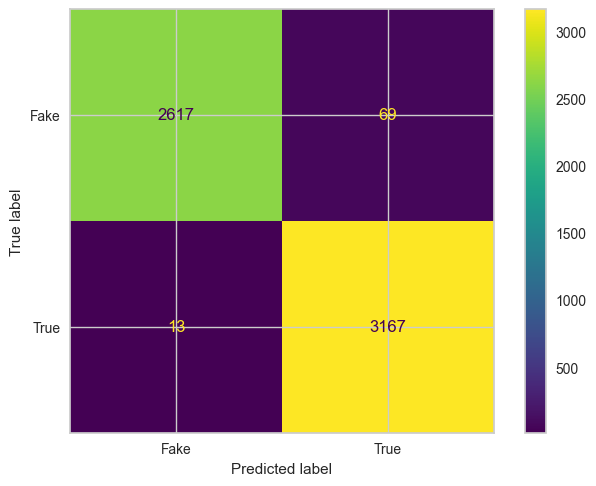

In [57]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Fake', 'True']).plot()
plt.show()

As we can see, our model classified almost all samples correctly. Let us take a look at the few remaining wrong samples.

#### Wrongly Predicted Samples

In [58]:
wrong_indices = y_val.index[y_pred != y_val]

X_wrong = X_val.loc[wrong_indices]
y_wrong_actual = y_val.loc[wrong_indices]

right_indices = y_val.index[y_pred == y_val]

X_right = X_val.loc[right_indices]
y_right_actual = y_val.loc[right_indices]


In [59]:
df_wrong = X_wrong.merge(y_wrong_actual, how='left', left_index=True,
                         right_index=True)
df_right = X_right.merge(y_right_actual, how='left', left_index=True,
                         right_index=True)


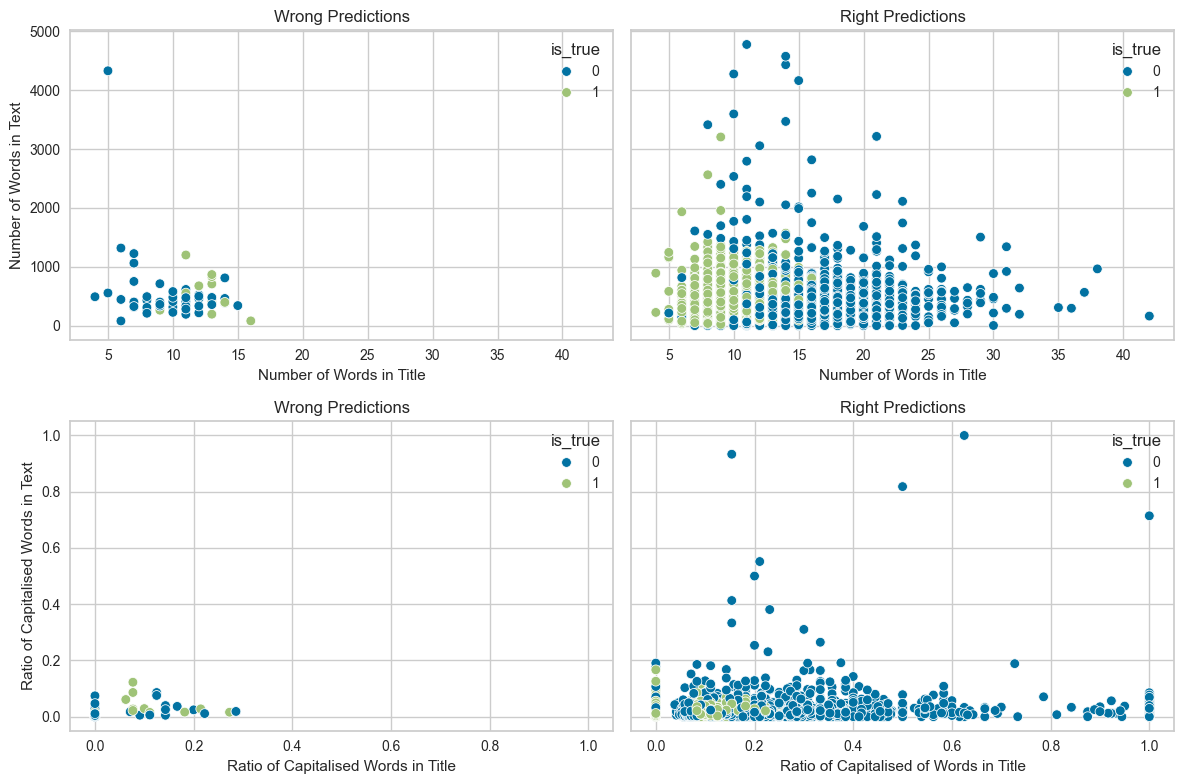

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='row', sharey='row')

sns.scatterplot(ax=axes[0, 0], x=df_wrong['n_words_title'],
                y=df_wrong['n_words_text'],
                hue=df_wrong['is_true'])
axes[0, 0].set_title('Wrong Predictions')
axes[0, 0].set_xlabel('Number of Words in Title')
axes[0, 0].set_ylabel('Number of Words in Text')

sns.scatterplot(ax=axes[0, 1], x=df_right['n_words_title'],
                y=df_right['n_words_text'],
                hue=df_right['is_true'])
axes[0, 1].set_title('Right Predictions')
axes[0, 1].set_xlabel('Number of Words in Title')
axes[0, 1].set_ylabel('Number of Words in Text')
sns.scatterplot(ax=axes[1, 0], x=df_wrong['ratio_capitalised_words_title'],
                y=df_wrong['ratio_capitalised_words_text'],
                hue=df_wrong['is_true'])
axes[1, 0].set_title('Wrong Predictions')
axes[1, 0].set_xlabel('Ratio of Capitalised Words in Title')
axes[1, 0].set_ylabel('Ratio of Capitalised Words in Text')

sns.scatterplot(ax=axes[1, 1], x=df_right['ratio_capitalised_words_title'],
                y=df_right['ratio_capitalised_words_text'],
                hue=df_right['is_true'])
axes[1, 1].set_title('Right Predictions')
axes[1, 1].set_xlabel('Ratio of Capitalised of Words in Title')
axes[1, 1].set_ylabel('Ratio of Capitalised of Words in Text')

plt.tight_layout()
plt.show()

As we can see, they are still part of the same area, although there are a lot less wrong samples than in previous iterations. Now, let's take a look at the most important tokens.

#### Feature Importance 

In [64]:
title_feature_names = 'title_' + \
                      model_pipeline.named_steps['preprocessor'].transformers_[
                          0][1].get_feature_names_out()
text_feature_names = 'text_' + \
                     model_pipeline.named_steps['preprocessor'].transformers_[
                         1][1].get_feature_names_out()

feature_names = np.concatenate([title_feature_names, text_feature_names,
                                ['n_words_title', 'n_words_text',
                                 'n_capitalised_words_title',
                                 'n_capitalised_words_text',
                                 'ratio_capitalised_words_title',
                                 'ratio_capitalised_words_text']])

coefficients = model_pipeline.named_steps['classifier'].coef_[0]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance',
                                                    ascending=False)

print(feature_importance.head(30))

                             Feature  Coefficient  Importance
5947                     title_video    -6.159062    6.159062
4844                      title_says     5.431414    5.431414
21927                      text_just    -4.596327    4.596327
36874                      text_wire    -4.489102    4.489102
6794                       text_21st    -4.365748    4.365748
35042                   text_tuesday     4.301298    4.301298
36608                 text_wednesday     4.204388    4.204388
34385                  text_thursday     3.998245    3.998245
2619                   title_hillary    -3.874897    3.874897
6796                     text_21wire    -3.851038    3.851038
18752                       text_gop    -3.680558    3.680558
11557                   text_century    -3.615298    3.615298
3020                      title_just    -3.601237    3.601237
24662                    text_monday     3.570835    3.570835
18102                    text_friday     3.475925    3.475925
22924   

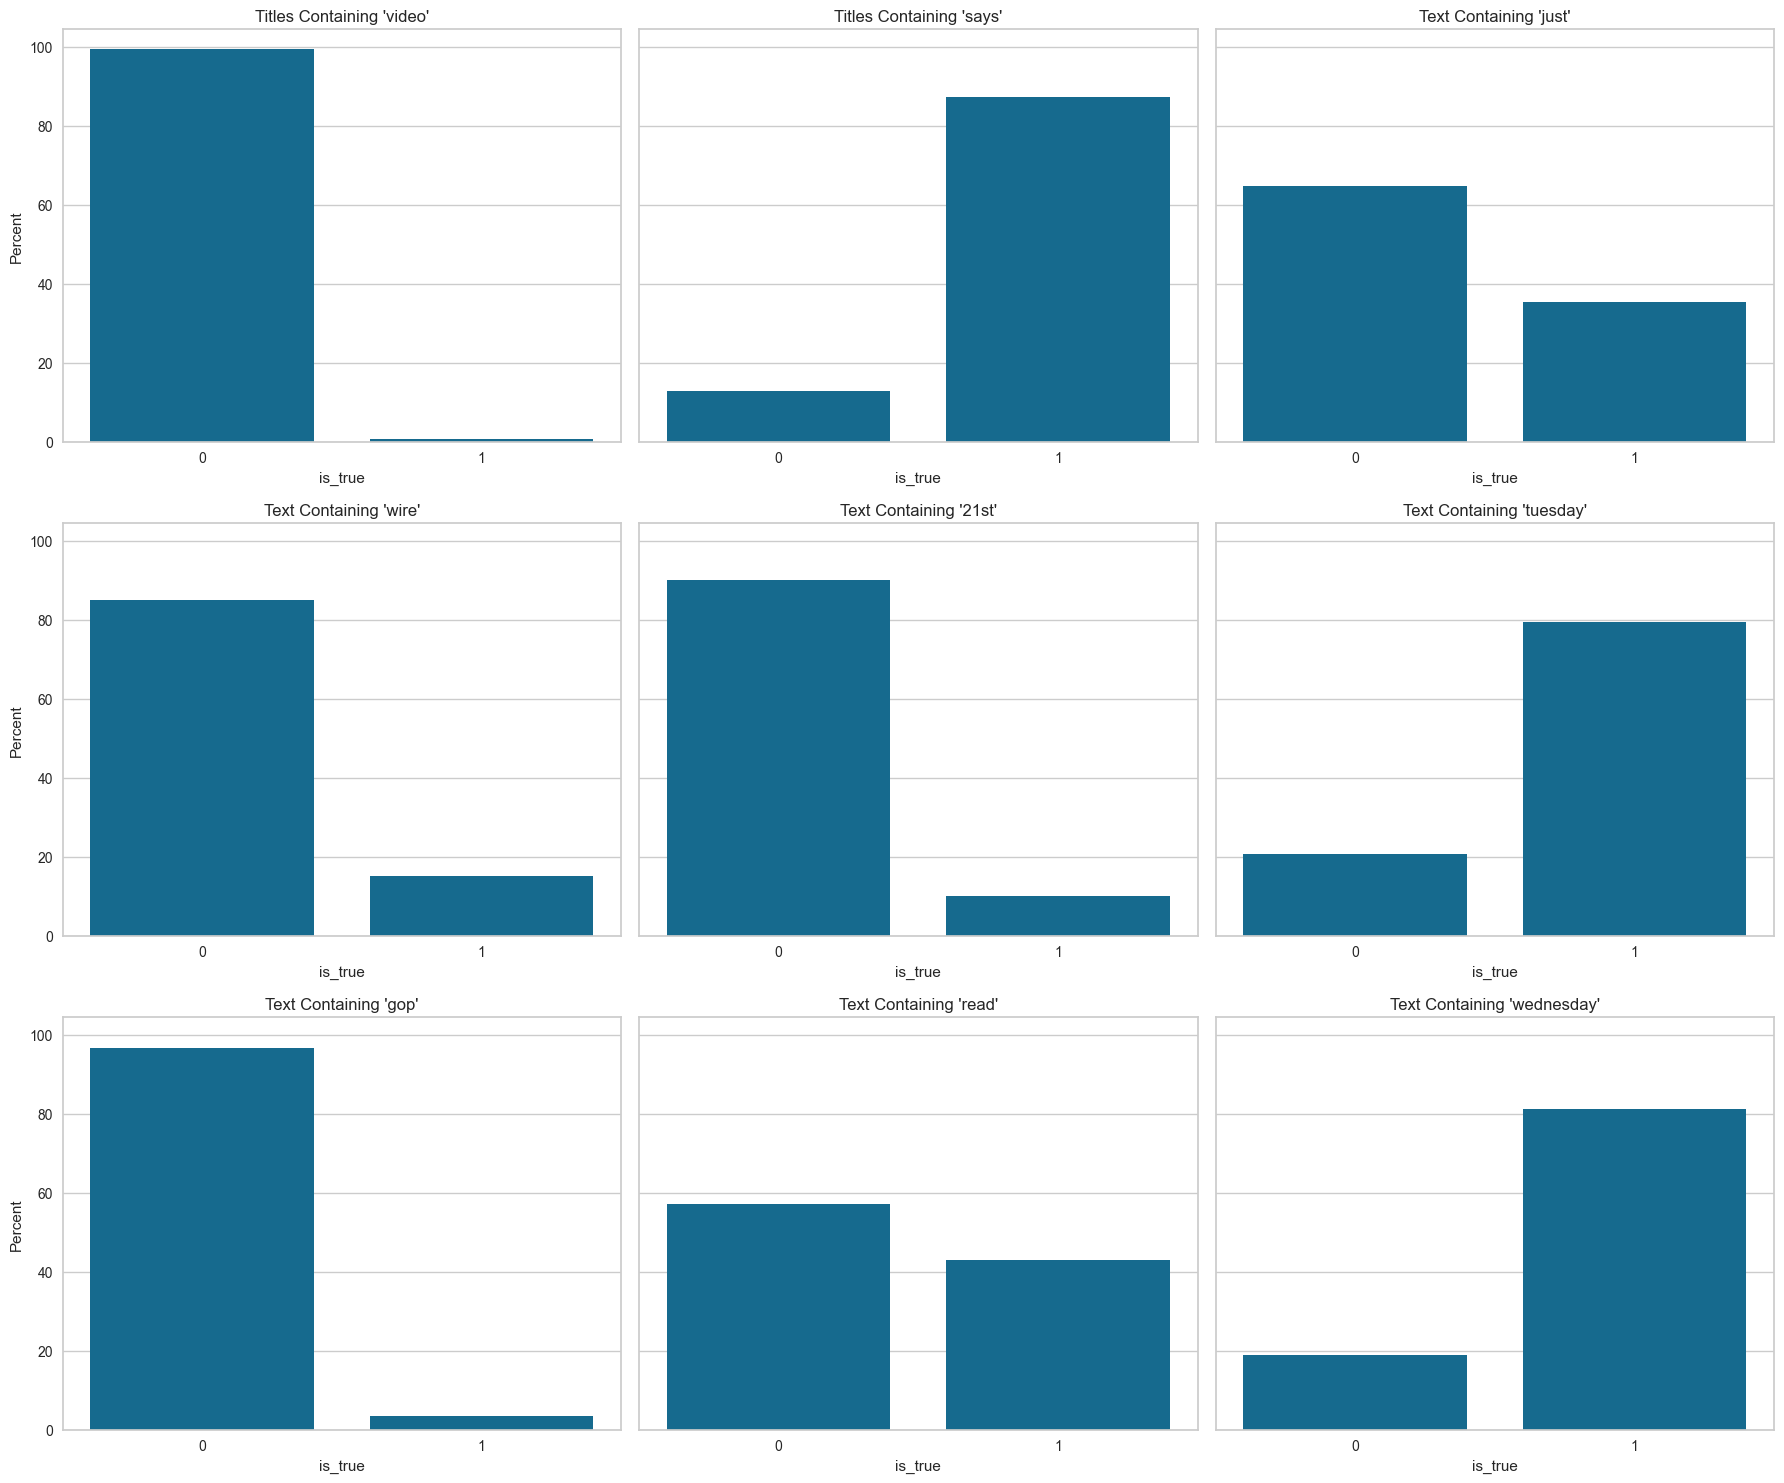

In [65]:

fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharey='all')

conditions = [
    ('title_video', "Titles Containing 'video'"),
    ('title_says', "Titles Containing 'says'"),
    ('text_just', "Text Containing 'just'"),
    ('text_wire', "Text Containing 'wire'"),
    ('text_21st', "Text Containing '21st'"),
    ('text_tuesday', "Text Containing 'tuesday'"),
    ('text_gop', "Text Containing 'gop'"),
    ('text_read', "Text Containing 'read'"),
    ('text_wednesday', "Text Containing 'wednesday'")
]

for ax, (condition, title) in zip(axes.flatten(), conditions):
    if 'title' in condition:
        sns.countplot(ax=ax, x=df_all[df_all['title'].str.lower().str.contains(
            condition.split('_')[1])].is_true, stat='percent')
    else:
        sns.countplot(ax=ax, x=df_all[df_all['text'].str.lower().str.contains(
            condition.split('_')[1])].is_true, stat='percent')
    ax.set_title(title)
    ax.set_xlabel('is_true')
    ax.set_ylabel('Percent')

plt.tight_layout()

plt.show()


As we can see, some of the tokens are extremely biased. For example, if an article contains the word "video", it is almost certain it will be fake. After performing LIME analysis to check how our model works, we will create a last model filtering out biased tokens.

#### LIME Analysis

In [66]:
def preprocess_text(text):
    words = text.split()
    words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
    words = [word.lower() for word in words if not word.isupper()]
    return ' '.join(words)


def predict_proba(texts):
    processed_texts = [preprocess_text(t) for t in texts]
    df = pd.DataFrame({
        'title': [t.split('|||')[0] for t in processed_texts],
        'text': [t.split('|||')[1] for t in processed_texts],
        'n_words_title': [len(t.split('|||')[0].split()) for t in
                          processed_texts],
        'n_words_text': [len(t.split('|||')[1].split()) for t in
                         processed_texts],
        'n_capitalised_words_title': [count_uppercase_words(t.split('|||')[0])
                                      for t in processed_texts],
        'n_capitalised_words_text': [count_uppercase_words(t.split('|||')[1])
                                     for t in processed_texts],
        'ratio_capitalised_words_title': [count_uppercase_words(t.split('|||')
                                                                [0]) / (len(
            t.split('|||')[0].split()) + 10e-5)
                                          for t in processed_texts],
        'ratio_capitalised_words_text': [
            count_uppercase_words(t.split('|||')[1])
            / (len(t.split('|||')[1].split()) + 10e-5)
            for t in processed_texts]
    })
    transformed_data = model_pipeline.named_steps['preprocessor'].transform(df)
    return model_pipeline.named_steps['classifier'].predict_proba(
        transformed_data)

In [67]:
explainer = LimeTextExplainer(class_names=["fake", "true"])
X_combined = X_wrong.apply(lambda row: row['title'] + '|||' + row['text'],
                           axis=1)
instance = X_combined.iloc[0]
exp = explainer.explain_instance(instance, predict_proba)
exp.show_in_notebook()

In [68]:
explainer = LimeTextExplainer(class_names=["fake", "true"])
X_combined = X_right.apply(lambda row: row['title'] + '|||' + row['text'],
                           axis=1)
instance = X_combined.iloc[0]
exp = explainer.explain_instance(instance, predict_proba)
exp.show_in_notebook()

### Filter out Biased Tokens

Finally, to filter out biased tokens, we have created a BiasedTokenRemover. This class removes tokens that are to be found almost exclusively in one of the two classes.

#### Modelling

In [70]:
biased_token_remover = BiasedTokenRemover(text_column='text',
                                          title_column='title', threshold=0.80)

In [71]:
custom_text_preprocessor = CustomTextPreprocessor(text_column='text', title_column='title')

In [73]:
df_all_test=df_all.copy()

In [78]:
def to_lowercase_unless_capitalized(text):
    words=[]
    for word in text.split():
        if word.isupper():
            words.append(word)
        else:
            words.append(word.lower())
    return ' '.join(words)

In [79]:
df_all_test['text']=df_all_test['text'].apply(to_lowercase_unless_capitalized)
df_all_test['title']=df_all_test['title'].apply(to_lowercase_unless_capitalized)

In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5,
                                 stop_words="english"), 'text'),
        ('title', TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5,
                                  stop_words="english"), 'title'),
        ('num_features', StandardScaler(), ['n_words_title', 'n_words_text',
                                            'n_capitalised_words_title',
                                            'n_capitalised_words_text',
                                            'ratio_capitalised_words_title',
                                            'ratio_capitalised_words_text'])
    ])

model_pipeline = Pipeline(steps=[
    ('biased_token_removal', biased_token_remover),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

X = df_all_test.drop('is_true', axis=1)
y = df_all_test['is_true']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                stratify=y_test)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_val)

In [82]:
joblib.dump(model_pipeline, 'models/model_ml_biased_token_remover.pkl')

['models/model_ml_biased_token_remover.pkl']

In [81]:
print(classification_report(y_val, y_pred, target_names=['Fake', 'True']))

              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98      2687
        True       0.97      0.99      0.98      3179

    accuracy                           0.98      5866
   macro avg       0.98      0.98      0.98      5866
weighted avg       0.98      0.98      0.98      5866



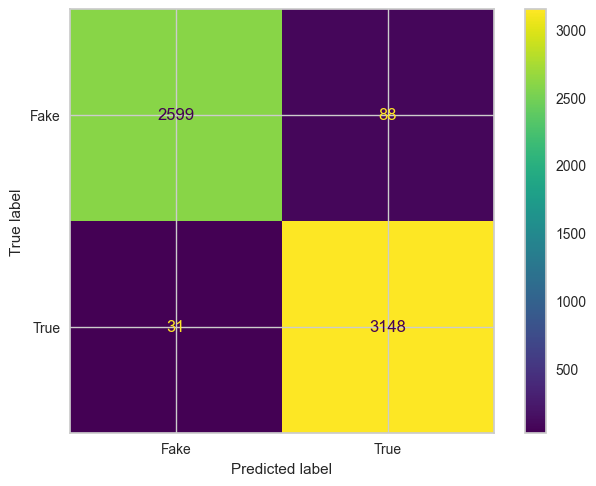

In [83]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Fake', 'True']).plot()
plt.show()

#### Wrongly Predicted Features

In [84]:
wrong_indices = y_val.index[y_pred != y_val]

X_wrong = X_val.loc[wrong_indices]
y_wrong_actual = y_val.loc[wrong_indices]

right_indices = y_val.index[y_pred == y_val]

X_right = X_val.loc[right_indices]
y_right_actual = y_val.loc[right_indices]

In [85]:
df_wrong = X_wrong.merge(y_wrong_actual, how='left', left_index=True,
                         right_index=True)
df_right = X_right.merge(y_right_actual, how='left', left_index=True,
                         right_index=True)

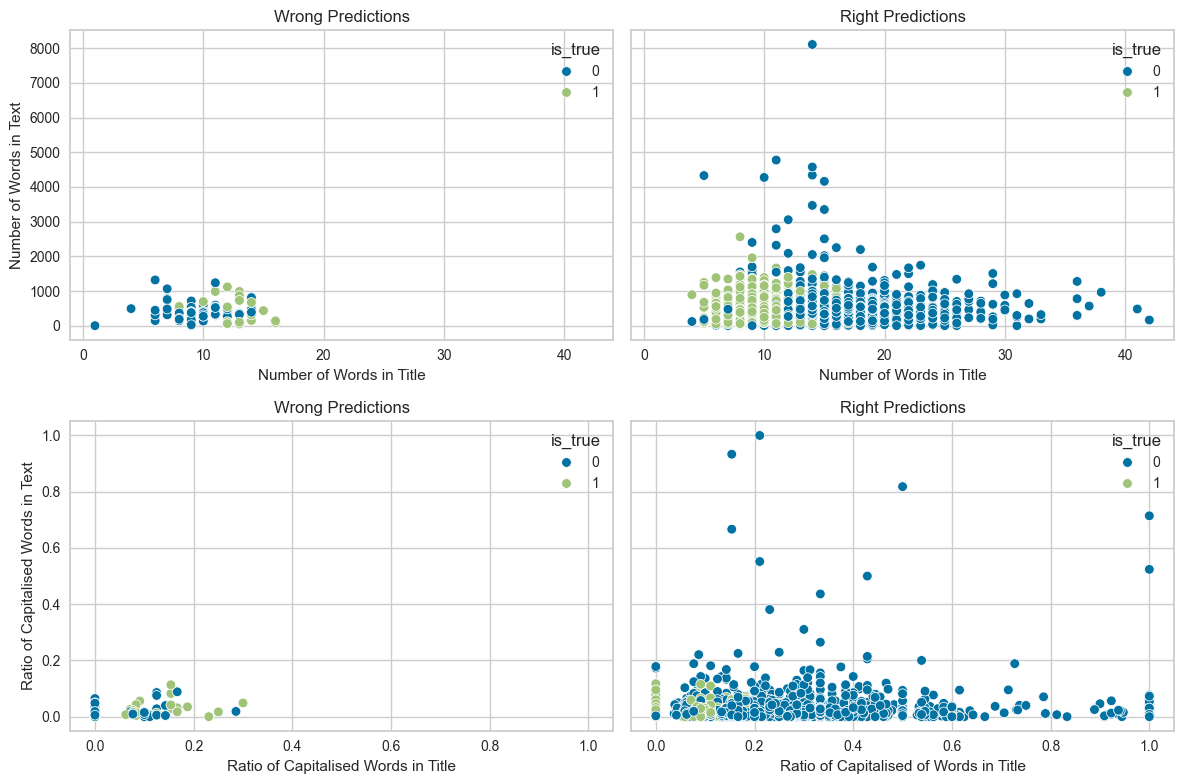

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='row', sharey='row')

sns.scatterplot(ax=axes[0, 0], x=df_wrong['n_words_title'],
                y=df_wrong['n_words_text'],
                hue=df_wrong['is_true'])
axes[0, 0].set_title('Wrong Predictions')
axes[0, 0].set_xlabel('Number of Words in Title')
axes[0, 0].set_ylabel('Number of Words in Text')

sns.scatterplot(ax=axes[0, 1], x=df_right['n_words_title'],
                y=df_right['n_words_text'],
                hue=df_right['is_true'])
axes[0, 1].set_title('Right Predictions')
axes[0, 1].set_xlabel('Number of Words in Title')
axes[0, 1].set_ylabel('Number of Words in Text')
sns.scatterplot(ax=axes[1, 0], x=df_wrong['ratio_capitalised_words_title'],
                y=df_wrong['ratio_capitalised_words_text'],
                hue=df_wrong['is_true'])
axes[1, 0].set_title('Wrong Predictions')
axes[1, 0].set_xlabel('Ratio of Capitalised Words in Title')
axes[1, 0].set_ylabel('Ratio of Capitalised Words in Text')

sns.scatterplot(ax=axes[1, 1], x=df_right['ratio_capitalised_words_title'],
                y=df_right['ratio_capitalised_words_text'],
                hue=df_right['is_true'])
axes[1, 1].set_title('Right Predictions')
axes[1, 1].set_xlabel('Ratio of Capitalised of Words in Title')
axes[1, 1].set_ylabel('Ratio of Capitalised of Words in Text')

plt.tight_layout()
plt.show()

#### Feature Importance

In [87]:
title_feature_names = 'title_' + \
                      model_pipeline.named_steps['preprocessor'].transformers_[
                          0][1].get_feature_names_out()
text_feature_names = 'text_' + \
                     model_pipeline.named_steps['preprocessor'].transformers_[
                         1][1].get_feature_names_out()

feature_names = np.concatenate([title_feature_names, text_feature_names,
                                ['n_words_title', 'n_words_text',
                                 'n_capitalised_words_title',
                                 'n_capitalised_words_text',
                                 'ratio_capitalised_words_title',
                                 'ratio_capitalised_words_text']])

coefficients = model_pipeline.named_steps['classifier'].coef_[0]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance',
                                                    ascending=False)

print(feature_importance.head(30))

                   Feature  Coefficient  Importance
3385         title_century    -6.634928    6.634928
23216            text_says     6.178262    6.178262
10118           title_just    -6.167301    6.167301
10661           title_like    -4.804922    4.804922
18030           title_told     4.735991    4.735991
18654         title_united     4.482686    4.482686
298         title_21wiretv    -4.271794    4.271794
21670         text_hillary    -4.256437    4.256437
13206  title_pictwittercom    -3.898312    3.898312
21950            text_just    -3.806952    3.806952
23899              text_uk     3.756914    3.756914
1393         title_america    -3.705636    3.705636
20328        text_breaking    -3.584194    3.584194
15665           title_says    -3.388330    3.388330
8107      title_government     3.295693    3.295693
15211          title_right    -3.268344    3.268344
16907      title_statement     3.230802    3.230802
19397           title_went    -3.013654    3.013654
2501        

#### LIME Analysis

In [88]:
explainer = LimeTextExplainer(class_names=["fake", "true"])
X_combined = X_wrong.apply(lambda row: row['title'] + '|||' + row['text'],
                           axis=1)
instance = X_combined.iloc[0]
exp = explainer.explain_instance(instance, predict_proba)
exp.show_in_notebook()

In [89]:
explainer = LimeTextExplainer(class_names=["fake", "true"])
X_combined = X_right.apply(lambda row: row['title'] + '|||' + row['text'],
                           axis=1)
instance = X_combined.iloc[0]
exp = explainer.explain_instance(instance, predict_proba)
exp.show_in_notebook()

### Final Prediction with Test Subset

Finally, we are going to use our last model to predict the test subset, which we have not used up until now.

In [90]:
y_pred = model_pipeline.predict(X_test)

In [91]:
print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))

              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98      2686
        True       0.97      0.99      0.98      3180

    accuracy                           0.98      5866
   macro avg       0.98      0.98      0.98      5866
weighted avg       0.98      0.98      0.98      5866



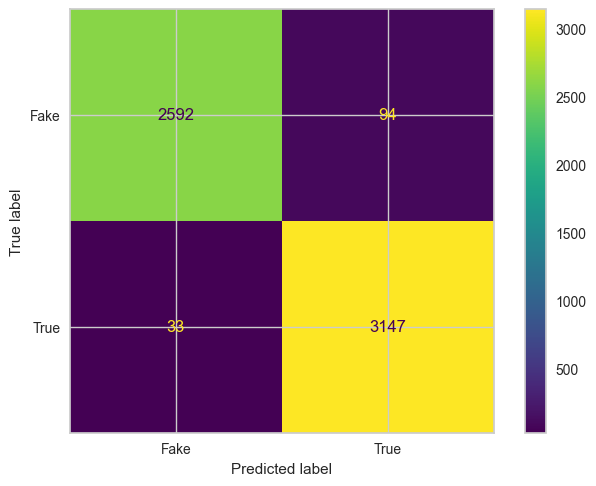

In [92]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Fake', 'True']).plot()
plt.show()

As we can see, the results are consistent with the validation subset, which means our model is properly fitted. We will compare it with a DL model, which we can find in the next notebook.

## Heuristic Rules

After all these iterations, we can come up with a series of rules to determine when an article is likely or not to be fake.

Keywords:
- If it contains "Reuters", especially if it mentions a location, it will almost certainly be true
- If it mentions featured images or links to Twitter, it will almost certainly be fake

Number of words:
- If the title contains more than 20 words, it will be fake
- If the text contains more than 5200 words, it will be fake

Capitalisation:
- If more than 42% of words in its title are capitalised, it is a fake article
- If more than 33% of words in its text are capitalised, it is a fake article

## Conclusion

In this notebook, we have used two datasets containing true and fake news. After removing duplicates, we have come up with several classification models, based on the title and body of the articles.

As a preliminary model, we have classified articles based on whether news agency Reuters is mentioned in the title. We obtained an accuracy of 99% using just that feature. However, in order to make our model more generalisable, we decided to remove mention to Reuters, as well as locations, in the title.

Next, using the number of words in text and title, we created a CatBoost Classifier model. This model had an accuracy of 86%, and mainly failed with samples with less than 20 words in the title.

Then, we added the number and ration of capitalised words in text and title. A word is considered to be capitalised when all its letters are in uppercase (eg. HOUSE). With an accuracy of 91.5%, this model, also a CatBoost Classifier, showed significant improvement with respect to the previous one.

Finally, using TF-IDF vectorizer, the text in columns text and title was tokenised. In this case, a pipeline was built to simplify the whole process. The accuracy for this model was 99% without filtering out biased tokens, and 98% when doing so.

This last model, with a BiasedTokenRemover, was tried in the test dataset, which had not been used yet at this point. With an accuracy of 98%, it can be determined to be properly fitted.

Lastly, heuristic rules were defined based on keywords, number of words, and capitalisation.

## Way Forward

In spite of the promising results achieved, this model would probably be 
significantly less performant with a different dataset. As it can be noticed 
from the heuristic rules, there are clear differences between the true and 
fake news datasets, which do not necessarily apply to the real world. As for 
the training process, these models should be retrained using only those 
samples that are harder to predict (eg. fake news with few words in title). 
Furthermore, when it comes to tokenising, an interesting approach would have 
been to distinguish uniquely between words that are CAPITALISED and the rest.

Similarly, it would be interesting to add new data that is closer in style to the opposite class and test and/or retrain the model to analyse how generalisable it can be.